In [1]:
import os
import itertools
from collections import Counter
import json
import statistics

from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import mixup, write_pickled_object, cohen_d, aggregate_ranks
from utils import get_stats as get_stats_best
from utils import RNAFeatureSelector, MeanCenterer

/orcd/pool/005/hmbaghda/miniforge3/envs/metastatic_potential/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'
random_state = 42

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [3]:
res = pd.read_csv(os.path.join(data_path, 'interim', 
                               'pipeline_model_selection_transcriptomics_individual.csv'), index_col = 0)
model_types = ['Ridge', 'ElasticNet', 'Lasso', 'PLS', 'SVR_linear',
               'SVR_poly', 'SVR_rbf', 'KNN', 'RFR']
res.model_type = pd.Categorical(res.model_type, categories = model_types, ordered = True)

First, let's get a rank-ordering across our two test metrics, MSE and Pearson correlation. For each model, we first aggregate by median value across folds. Then, we calculate the rank of the model (lower rank = better performance) for each test metric. Finally, we aggregate across test metrics using the stringent maximum rank per model -- what is the worse the model performed.

In [4]:
rank_order = aggregate_ranks(
    opt_res=res.groupby('model_type', observed = True)[['test_mse', 'test_corr']].median().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'higher'
    },
    method = 'max'
)
model_order = rank_order['model_type'].tolist()
rank_order

,model_type,test_mse,test_corr,test_mse_rank,test_corr_rank,consensus_score,consensus_rank
0,SVR_rbf,1.781179,0.525056,1.0,1.0,1.0,1.0
1,SVR_poly,1.858890,0.512253,2.0,2.0,2.0,2.0
2,SVR_linear,1.897212,0.474946,4.0,5.0,5.0,3.0
3,ElasticNet,1.872144,0.471578,3.0,6.0,6.0,4.0
4,Lasso,1.948779,0.468527,5.0,7.0,7.0,5.5
5,PLS,1.990378,0.482891,7.0,4.0,7.0,5.5
6,Ridge,1.998815,0.499426,8.0,3.0,8.0,7.5
7,RFR,1.989970,0.452182,6.0,8.0,8.0,7.5
8,KNN,2.072908,0.382839,9.0,9.0,9.0,9.0


Let's take a look at the results from the model selection:

In [5]:
# sort by median correlation
rank_order.sort_values(by = 'test_corr', ascending = False)[['model_type', 'test_corr']]

,model_type,test_corr
0,SVR_rbf,0.525056
1,SVR_poly,0.512253
6,Ridge,0.499426
5,PLS,0.482891
2,SVR_linear,0.474946
3,ElasticNet,0.471578
4,Lasso,0.468527
7,RFR,0.452182
8,KNN,0.382839


In [6]:
# sort by median correlation
rank_order.sort_values(by = 'test_mse')[['model_type', 'test_mse']]

,model_type,test_mse
0,SVR_rbf,1.781179
1,SVR_poly,1.858890
3,ElasticNet,1.872144
2,SVR_linear,1.897212
4,Lasso,1.948779
7,RFR,1.989970
5,PLS,1.990378
6,Ridge,1.998815
8,KNN,2.072908


In [7]:
# sort by correlation variance
res.groupby('model_type', observed = True).test_corr.var().sort_values(ascending = True)

model_type
PLS           0.008473
Ridge         0.013381
SVR_linear    0.014371
SVR_rbf       0.014704
SVR_poly      0.015070
RFR           0.016531
ElasticNet    0.017150
Lasso         0.020568
KNN           0.022237
Name: test_corr, dtype: float64

In [8]:
# sort by mse variance
res.groupby('model_type', observed = True).test_mse.var().sort_values(ascending = True)

model_type
SVR_rbf       0.125935
Ridge         0.141729
RFR           0.145979
PLS           0.149847
ElasticNet    0.151074
SVR_linear    0.152894
Lasso         0.159563
SVR_poly      0.160087
KNN           0.183318
Name: test_mse, dtype: float64

Let's compare each models performance with identified best hyperparameters for a specific fold:

In [9]:
res_stats = pd.DataFrame(columns = ['comparison', 'pval_corr', 'cohen_d_corr', 
                                   'pval_mse', 'cohen_d_mse'])
mod_combs = itertools.combinations((res.model_type.unique()), 2)

for mc in mod_combs:
    a = res[res.model_type == mc[0]]
    b = res[res.model_type == mc[1]]
    
    pval_corr = stats.mannwhitneyu(a.test_corr,b.test_corr).pvalue
    cd_corr = cohen_d(a.test_corr,b.test_corr)
    
    pval_mse = stats.mannwhitneyu(a.test_mse,b.test_mse).pvalue
    cd_mse = cohen_d(a.test_mse,b.test_mse)
    
    res_stats.loc[res_stats.shape[0], :] = [mc, pval_corr, cd_corr, pval_mse, cd_mse]
    
_, fdr_corr, _, _ = multipletests(res_stats.pval_corr.values, method='fdr_bh')
_, fdr_mse, _, _ = multipletests(res_stats.pval_mse.values, method='fdr_bh')
res_stats['fdr_corr'] = fdr_corr
res_stats['fdr_mse'] = fdr_mse
res_stats.to_csv(os.path.join(data_path, 'processed', 'transcriptomics_comparison_stats.csv'))
res_stats

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
0,"(SVR_linear, PLS)",0.909722,-0.087216,0.623176,-0.147946,0.992424,0.982349
1,"(SVR_linear, Ridge)",0.850107,-0.073592,0.73373,-0.129467,0.992424,0.982349
2,"(SVR_linear, Lasso)",0.96985,0.070823,0.850107,-0.023002,0.99756,0.992424
3,"(SVR_linear, ElasticNet)",1.0,-0.009759,0.909722,0.017447,1.0,0.992424
4,"(SVR_linear, SVR_poly)",0.623176,-0.232326,0.57075,0.211244,0.975406,0.982349
5,"(SVR_linear, SVR_rbf)",0.472676,-0.281399,0.472676,0.285234,0.975406,0.982349
6,"(SVR_linear, RFR)",0.520523,0.220004,0.384673,-0.2424,0.975406,0.982349
7,"(SVR_linear, KNN)",0.307489,0.526452,0.57075,-0.308853,0.975406,0.982349
8,"(PLS, Ridge)",0.909722,0.006239,1.0,0.02061,0.992424,1.0
9,"(PLS, Lasso)",0.909722,0.155035,0.791337,0.123228,0.992424,0.982349


In [10]:
res_stats[['fdr_corr', 'fdr_mse']].min().min()

0.975406263467662

In [11]:
res_stats[['fdr_corr', 'fdr_mse']].min().min()

0.975406263467662

In [12]:
res_stats[res_stats.fdr_corr <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse


There are no significant differences in model performance by either Pearson correlation or MSE.

To reduce the multiple testing burden, let's also subset to our top 3 models by rank, and see whether there are any significant differences in this case.

In [13]:
res_sub = res[res.model_type.isin(model_order[:3])].copy()

res_sub_stats = pd.DataFrame(columns = ['comparison', 'pval_corr', 'cohen_d_corr', 
                                   'pval_mse', 'cohen_d_mse'])
mod_combs = itertools.combinations((res_sub.model_type.unique()), 2)

for mc in mod_combs:
    a = res_sub[res_sub.model_type == mc[0]]
    b = res_sub[res_sub.model_type == mc[1]]
    
    pval_corr = stats.mannwhitneyu(a.test_corr,b.test_corr).pvalue
    cd_corr = cohen_d(a.test_corr,b.test_corr)
    
    pval_mse = stats.mannwhitneyu(a.test_mse,b.test_mse).pvalue
    cd_mse = cohen_d(a.test_mse,b.test_mse)
    
    res_sub_stats.loc[res_sub_stats.shape[0], :] = [mc, pval_corr, cd_corr, pval_mse, cd_mse]
    
_, fdr_corr, _, _ = multipletests(res_sub_stats.pval_corr.values, method='fdr_bh')
_, fdr_mse, _, _ = multipletests(res_sub_stats.pval_mse.values, method='fdr_bh')
res_sub_stats['fdr_corr'] = fdr_corr
res_sub_stats['fdr_mse'] = fdr_mse
# res_sub_stats.to_csv(os.path.join(data_path, 'processed', 'transcriptomics_comparison_stats.csv'))
res_sub_stats

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
0,"(SVR_linear, SVR_poly)",0.623176,-0.232326,0.57075,0.211244,0.677585,0.856126
1,"(SVR_linear, SVR_rbf)",0.472676,-0.281399,0.472676,0.285234,0.677585,0.856126
2,"(SVR_poly, SVR_rbf)",0.677585,-0.047056,0.909722,0.06065,0.677585,0.909722


We can see that even here, none of our models have significant differences in performance. 

/tmp/ipykernel_1306296/72843879.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = axA[i],
/tmp/ipykernel_1306296/72843879.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axA[i].set_xticklabels(xlabels,
/tmp/ipykernel_1306296/72843879.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = axA[i],
/tmp/ipykernel_1306296/72843879.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axA[i].set_x

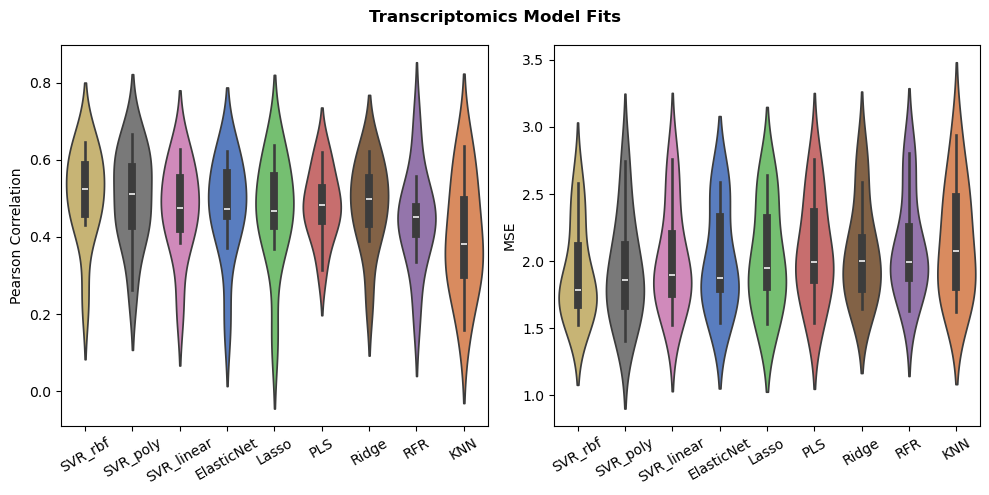

In [14]:
figA, axA = plt.subplots(ncols = 2, figsize = (10,5))

metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))
# order_map = dict(zip(metric_types, [corr_order, mse_order]))
order_map = dict(zip(metric_types, [model_order, model_order]))

palette = dict(zip(sorted(res.model_type.unique()), sns.color_palette("muted")))

for i, metric_type in enumerate(metric_types):
    # sort by mean of metric
    res.model_type = pd.Categorical(res.model_type, categories = order_map[metric_type], 
                               ordered = True)
    
    
    sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = axA[i], 
                  palette = palette)#,
#                    fill = False, inner = None)
    
#     sns.boxplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                 width=0.1, 
#                 color="black", showcaps=False, boxprops={'facecolor':'none'}, 
#                 whiskerprops={'linewidth':0.5}, ax = axA[i])
#     sns.stripplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                   alpha=0.5, jitter=True, dodge=True, ax = axA[i], color = 'black')
    
    axA[i].set_xlabel('')
    axA[i].set_ylabel(mmap[metric_type])
    
    xlabels = [x._text for x in axA[i].get_xticklabels()]
    x_pos = dict(zip(xlabels, axA[i].get_xticks()))
    y, h = axA[i].get_ylim()[1], 0.05
    
    axA[i].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
    
    sig_counter = 0
    for j, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2
        
        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr_' + metric_type].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d_' + metric_type].values[0]
        
        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"
        
        if significance != 'N.S.':
            y_pos = y+(sig_counter*0.15)
            axA[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                       [y_pos, y_pos+h, y_pos+h, y_pos], 
                       lw=1.5, c='black')
            y_pos*=1.01
            axA[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1

#     axA[i].grid(axis='y', linestyle='--', alpha=0.7)
    
figA.suptitle('Transcriptomics Model Fits',
    fontweight='bold',  # Makes the text bold
)
figA.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'all_models_transcriptomics.png'), 
            dpi=300, 
            bbox_inches="tight")  


For each metric (panels), violin plots are ordered by the best performing rank across folds. Each fold has the best model selected using optuna hyperparameter tuning. We observe the following: 
- there are no significant differences in any of the model performance for both correlation and MSE
- relative model performance is consistent between correlation and MSE, with SVMs performing best
- the worse performing models tend to have higher variance across folds

Thus, for this dataset, non-linear models do not outperform linear models.

# Consensus model

In [15]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'), index_col = 0)['mean'].values.ravel()
X.shape

(481, 16371)

Given that SVMs perform best and there are no significant differences, we proceed with the linear SVM as it is more interpretable. We generate a consensus model based on the hyperparameters selected across folds. We assess how that consensus model performs across a 10-fold split that is different than the one run during Notebook 02.

In [16]:
model_type = 'SVR_linear'
print(model_type)

res_model = res[res.model_type == model_type]

n_features_best = []
C_best = []
epsilon_best = []
for k, bp in enumerate(res_model.best_params):
    n_features = int(bp.split(', ')[0].split(': ')[1])
    C = float(bp.split(', ')[1].split(': ')[1])
    epsilon = float(bp.split(', ')[2].split(': ')[1][:-1])
    
    n_features_best.append(n_features)
    C_best.append(C)
    epsilon_best.append(epsilon)
    
    
    print('Fold: {}, features: {}, C: {:4f}, epsilon: {:.4f}'.format(k, n_features, C, epsilon))

    
n_features_best = statistics.mode(n_features_best)
C_best = np.mean(C)
epsilon_best = np.mean(epsilon_best)


print('The connsensus model has features: {}, C: {:4f}, epsilon: {:.4f}'.format(n_features_best, C_best, epsilon_best))


best_steps = [
    ("feature_reduction", RNAFeatureSelector(n_features = n_features_best)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='linear',
    C=C_best,
    epsilon=epsilon_best
)))
best_pipeline = Pipeline(best_steps)
write_pickled_object(best_pipeline, 
                    os.path.join(data_path, 'processed', 'best_model.pickle'))
best_pipeline

SVR_linear
Fold: 0, features: 16371, C: 0.005219, epsilon: 0.9146
Fold: 1, features: 16371, C: 0.144415, epsilon: 0.7542
Fold: 2, features: 5000, C: 0.011149, epsilon: 0.8303
Fold: 3, features: 10000, C: 0.352304, epsilon: 0.8398
Fold: 4, features: 16371, C: 0.342095, epsilon: 0.9896
Fold: 5, features: 16371, C: 0.036512, epsilon: 0.9481
Fold: 6, features: 16371, C: 0.003151, epsilon: 0.4794
Fold: 7, features: 16371, C: 0.128187, epsilon: 0.7723
Fold: 8, features: 16371, C: 0.092911, epsilon: 0.8548
Fold: 9, features: 10000, C: 0.001639, epsilon: 0.9632
The connsensus model has features: 16371, C: 0.001639, epsilon: 0.8346


,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,16371
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001


We see that consistently, all features were selected. For the C and epsilon hyperparameters, we take the mean value across folds.

Let's also see how the other SVMs perform, since they were highly ranked:

In [17]:
model_type = 'SVR_linear'
print(model_type)

res_model = res[res.model_type == model_type]

n_features_best = []
C_best = []
epsilon_best = []
for k, bp in enumerate(res_model.best_params):
    n_features = int(bp.split(', ')[0].split(': ')[1])
    C = float(bp.split(', ')[1].split(': ')[1])
    epsilon = float(bp.split(', ')[2].split(': ')[1][:-1])
    
    n_features_best.append(n_features)
    C_best.append(C)
    epsilon_best.append(epsilon)
    
    
    print('Fold: {}, features: {}, C: {:4f}, epsilon: {:.4f}'.format(k, n_features, C, epsilon))

    
n_features_best = statistics.mode(n_features_best)
C_best = np.mean(C_best)
epsilon_best = np.mean(epsilon_best)


print('The connsensus model has features: {}, C: {:4f}, epsilon: {:.4f}'.format(n_features_best, C_best, epsilon_best))


best_steps = [
    ("feature_reduction", RNAFeatureSelector(n_features = n_features_best)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='linear',
    C=C_best,
    epsilon=epsilon_best
)))
best_pipeline = Pipeline(best_steps)
write_pickled_object(best_pipeline, 
                    os.path.join(data_path, 'processed', 'best_model.pickle'))
best_pipeline

SVR_linear
Fold: 0, features: 16371, C: 0.005219, epsilon: 0.9146
Fold: 1, features: 16371, C: 0.144415, epsilon: 0.7542
Fold: 2, features: 5000, C: 0.011149, epsilon: 0.8303
Fold: 3, features: 10000, C: 0.352304, epsilon: 0.8398
Fold: 4, features: 16371, C: 0.342095, epsilon: 0.9896
Fold: 5, features: 16371, C: 0.036512, epsilon: 0.9481
Fold: 6, features: 16371, C: 0.003151, epsilon: 0.4794
Fold: 7, features: 16371, C: 0.128187, epsilon: 0.7723
Fold: 8, features: 16371, C: 0.092911, epsilon: 0.8548
Fold: 9, features: 10000, C: 0.001639, epsilon: 0.9632
The connsensus model has features: 16371, C: 0.111758, epsilon: 0.8346


,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,16371
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001


In [18]:
model_type = 'SVR_rbf'
print(model_type)

res_model = res[res.model_type == model_type]

n_features_best = []
C_best = []
epsilon_best = []
gamma_best = []
for bp in res_model.best_params:
    n_features = int(bp.split(', ')[0].split(': ')[1])
    C = float(bp.split(', ')[1].split(': ')[1])
    epsilon = float(bp.split(', ')[2].split(': ')[1])
    gamma = eval((bp.split(', ')[3].split(': ')[1][:-1]))
    
    n_features_best.append(n_features)
    C_best.append(C)
    epsilon_best.append(epsilon)
    gamma_best.append(gamma)
    
    
    print('Fold: {}, features: {}, C: {:4f}, epsilon: {:.4f}, gamma: {}'.format(k, n_features, C, epsilon, gamma))
    
n_features_best = statistics.mode(n_features_best)
C_best = np.mean(C_best)
epsilon_best = np.mean(epsilon_best)
gamma_best = statistics.mode(gamma_best)
print('The connsensus model has features: {}, C: {:4f}, epsilon: {:.4f}, gamma: {}'.format(
    n_features_best, C_best, epsilon_best, gamma_best))

    
    
best_steps = [
    ("feature_reduction", RNAFeatureSelector(n_features = n_features_best)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='rbf',
    C=C_best,
    epsilon=epsilon_best,
    gamma = gamma_best
)))
best_pipeline_rbf = Pipeline(best_steps)
write_pickled_object(best_pipeline_rbf, 
                    os.path.join(data_path, 'processed', 'best_model_svr_rbf_transcriptomics.pickle'))
best_pipeline_rbf

SVR_rbf
Fold: 9, features: 16371, C: 7.684487, epsilon: 0.2246, gamma: auto
Fold: 9, features: 10000, C: 41.825267, epsilon: 0.0245, gamma: scale
Fold: 9, features: 16371, C: 26.889267, epsilon: 0.0216, gamma: auto
Fold: 9, features: 5000, C: 79.529066, epsilon: 0.1170, gamma: scale
Fold: 9, features: 16371, C: 65.712628, epsilon: 0.2211, gamma: scale
Fold: 9, features: 10000, C: 2.858730, epsilon: 0.0377, gamma: scale
Fold: 9, features: 16371, C: 29.107757, epsilon: 0.0022, gamma: scale
Fold: 9, features: 16371, C: 90.473410, epsilon: 0.0640, gamma: scale
Fold: 9, features: 16371, C: 3.023316, epsilon: 0.1466, gamma: scale
Fold: 9, features: 10000, C: 17.945840, epsilon: 0.2114, gamma: scale
The connsensus model has features: 16371, C: 36.504977, epsilon: 0.1071, gamma: scale


,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,16371
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001


In [19]:
model_type = 'SVR_poly'
print(model_type)

res_model = res[res.model_type == model_type]

n_features_best = []
C_best = []
epsilon_best = []
degree_best = []
gamma_best = []
coef0_best = []
gamma_best = []
for bp in res_model.best_params:
    n_features = int(bp.split(', ')[0].split(': ')[1])
    C = float(bp.split(', ')[1].split(': ')[1])
    epsilon = float(bp.split(', ')[2].split(': ')[1])
    degree = int(bp.split(', ')[3].split(': ')[1])
    coef0 = float(bp.split(', ')[4].split(': ')[1])
    gamma = eval(bp.split(', ')[5].split(': ')[1][:-1])

    n_features_best.append(n_features)
    C_best.append(C)
    epsilon_best.append(epsilon)
    degree_best.append(degree)
    coef0_best.append(coef0)
    gamma_best.append(gamma)
    
    print('Fold: {}, features: {}, C: {:4f}, epsilon: {:.4f}, gamma: {}, degree: {}, coef0: {:.2f}'.format(
        k, n_features, C, epsilon, gamma, degree, coef0))

n_features_best = statistics.mode(n_features_best)
C_best = np.mean(C_best)
epsilon_best = np.mean(epsilon_best)
gamma_best = statistics.mode(gamma_best)
degree_best = statistics.mode(degree_best)
coef0_best = np.mean(coef0_best)
print('The connsensus model has features: {}, C: {:4f}, epsilon: {:.4f}, gamma: {}, degree: {}, coef0: {:.2f}'.format(
    n_features_best, C_best, epsilon_best, gamma_best, degree_best, coef0_best))    
    
    
best_steps = [
    ("feature_reduction", RNAFeatureSelector(n_features = n_features_best)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='poly',
    C=C_best,
    epsilon=epsilon_best,
    gamma = gamma_best, 
    degree = degree_best, 
    coef0 = coef0_best

)))
best_pipeline_poly = Pipeline(best_steps)
write_pickled_object(best_pipeline_poly, 
                    os.path.join(data_path, 'processed', 'best_model_svr_poly_transcriptomics.pickle'))
best_pipeline_poly

SVR_poly
Fold: 9, features: 16371, C: 20.956037, epsilon: 0.0025, gamma: scale, degree: 4, coef0: 2.00
Fold: 9, features: 10000, C: 4.475650, epsilon: 0.0711, gamma: auto, degree: 3, coef0: 2.00
Fold: 9, features: 16371, C: 0.588799, epsilon: 0.0096, gamma: scale, degree: 4, coef0: 1.60
Fold: 9, features: 10000, C: 4.162076, epsilon: 0.0162, gamma: scale, degree: 3, coef0: 1.20
Fold: 9, features: 10000, C: 8.111427, epsilon: 0.0019, gamma: scale, degree: 5, coef0: 1.60
Fold: 9, features: 16371, C: 1.358702, epsilon: 0.0548, gamma: auto, degree: 3, coef0: 1.40
Fold: 9, features: 10000, C: 4.490893, epsilon: 0.1697, gamma: auto, degree: 2, coef0: 1.40
Fold: 9, features: 16371, C: 49.953159, epsilon: 0.2116, gamma: auto, degree: 3, coef0: 1.20
Fold: 9, features: 10000, C: 3.299264, epsilon: 0.0398, gamma: auto, degree: 2, coef0: 0.50
Fold: 9, features: 10000, C: 9.479718, epsilon: 0.2426, gamma: scale, degree: 2, coef0: 0.30
The connsensus model has features: 10000, C: 10.687572, epsilon:

,steps,"[('feature_reduction', ...), ('mean_centering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,method,'top_residuals'
,n_features,10000
,kernel,'poly'
,degree,3
,gamma,'scale'
,coef0,1.3200000000000003
,tol,0.001


RBF and poly also had auto selected most often for the gamma hyperparameter, so we use that. Other hyperparameters are selected using the mean value as in the linear. 

In [20]:
# np.random.seed(random_state)
# outer_cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
# n_synthetic = 1000
# augment = False
# # res = {}

# baseline_linear = LinearRegression(n_jobs = n_cores)

# results = []
# fold_idx = {} # for Nikos to run NN

# for k, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y))):
#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
    
#     fold_idx[k] = {'train_idx': train_idx.tolist(), 
#                   'test_idx': test_idx.tolist()}
    
#     # augment data
#     if augment:
#         synthetic_X, synthetic_y = mixup(X_train, y_train, n_synthetic = n_synthetic, alpha = 2, 
#                                          random_state = random_state)
#         X_train = np.concatenate((X_train, synthetic_X), axis = 0)
#         y_train = np.concatenate((y_train, synthetic_y), axis = 0)

#     train_corr, test_corr, train_mse, test_mse, r2 = get_stats_best(best_pipeline, 
#                                                                     y_train, y_test, 
#                                                                     X_train, X_test, 
#                                                                    get_cod = True)    
#     # random - y
#     y_train_rand = np.random.permutation(y_train)
#     res_y_rand = get_stats_best(best_pipeline, y_train_rand, y_test, X_train, X_test)
#     _, test_corr_y_rand, _, test_mse_y_rand = res_y_rand    
    
#     # random - X (features)
#     X_train_rand = X_train[:, np.random.permutation(X_train.shape[1])]
#     res_X_rand = get_stats_best(best_pipeline, y_train, y_test, X_train_rand, X_test)
#     _, test_corr_X_rand, _, test_mse_X_rand = res_X_rand  
    
# #     # linear simple
# #     linear_res = get_stats(baseline_linear, y_train, y_test, X_train, X_test)
# #     _, test_corr_linear, _, test_mse_linear = linear_res
    
#     train_corr_rbf, test_corr_rbf, train_mse_rbf, test_mse_rbf = get_stats_best(best_pipeline_rbf, y_train, y_test, X_train, X_test)
#     train_corr_poly, test_corr_poly, train_mse_poly, test_mse_poly = get_stats_best(best_pipeline_poly, y_train, y_test, X_train, X_test)

#     results.append({
#         "fold": k,
#         "train_corr": train_corr,
#         "test_corr": test_corr,
#         'train_mse': train_mse, 
#         'test_mse': test_mse,
#         'test_r2': r2, # coef of determination for test data
#         'random_y_test_corr': test_corr_y_rand, 
#         'random_y_test_mse': test_mse_y_rand, 
#         'random_X_test_corr': test_corr_X_rand, 
#         'random_X_test_mse': test_mse_X_rand, 
# #         'linear_baseline_test_corr': test_corr_linear, 
# #         'linear_baseline_test_mse': test_mse_linear, 
        
#         "train_corr_rbf": train_corr_rbf,
#         "test_corr_rbf": test_corr_rbf,
#         'train_mse_rbf': train_mse_rbf, 
#         'test_mse_rbf': test_mse_rbf,
        
#         "train_corr_poly": train_corr_poly,
#         "test_corr_poly": test_corr_poly,
#         'train_mse_poly': train_mse_poly, 
#         'test_mse_poly': test_mse_poly,
#         })
#     best_res_df = pd.DataFrame(results)

# best_res_df.to_csv(os.path.join(data_path, 'processed', 'transcriptomics_consensus_performance.csv'))
# with open(os.path.join(data_path, 'interim', 'transcriptomics_consensus_folds.json'), "w") as json_file:
#     json.dump(fold_idx, json_file, indent=4) 
    
best_res_df = pd.read_csv(os.path.join(data_path, 'processed', 'transcriptomics_consensus_performance.csv'), 
                         index_col = 0)


Get the consensus rank as before:

In [21]:
best_res_df_ = best_res_df.rename(columns = {
    'test_corr': 'test_corr_svr_linear', 
    'test_mse': 'test_mse_svr_linear'
})
best_res_df_ = best_res_df_[
    ['fold', 'test_corr_svr_linear','test_mse_svr_linear', 'test_corr_rbf',  'test_mse_rbf', 
    'test_corr_poly', 'test_mse_poly']
]

best_res_df_ = (
    best_res_df_
        .melt(id_vars='fold', value_name='value')
        .assign(
            metric=lambda x: x.variable.str.split('_').str[:2].str.join('_'),
            model_type=lambda x: x.variable.str.split('_').str[2:].str.join('_')
        )
        .pivot(index=['fold', 'model_type'], columns='metric', values='value')
        .reset_index()[['fold', 'model_type', 'test_mse', 'test_corr']]
)

best_res_df_.model_type = best_res_df_.model_type.apply(lambda x: x if x.startswith('svr_') else 'svr_' + x)

rank_order = aggregate_ranks(
    opt_res=best_res_df_.groupby('model_type', observed = True)[['test_mse', 'test_corr']].median().reset_index(), 
    feature_col = 'model_type', 
    metric_directions = {
        'test_mse': 'lower', 
        'test_corr': 'higher'
    },
    method = 'max'
)
rank_order

metric,model_type,test_mse,test_corr,test_mse_rank,test_corr_rank,consensus_score,consensus_rank
0,svr_poly,1.818658,0.517459,1.0,2.0,2.0,1.5
1,svr_rbf,1.847587,0.540631,2.0,1.0,2.0,1.5
2,svr_linear,1.987183,0.507134,3.0,3.0,3.0,3.0


In [22]:
best_res_df['test_corr'].median()

0.5071335306510102

In [23]:
best_res_df['test_corr'].mean()

0.4845486603363639

In [24]:
best_res_df['test_corr'].mean()**2 # only equals coefficient of determination under certain assumptions

0.23478740423376496

In [25]:
best_res_df['test_r2'].mean() # coefficient of determination
best_res_df.drop(columns = ['test_r2'], inplace = True)

In [26]:
def get_stats(viz_df, random: bool, metric_type):
    res_stats = pd.DataFrame(columns = ['comparison', 'pval', 'cohen_d'])
    mod_combs = list(itertools.combinations((viz_df['Model Type'].unique()), 2))
    if random:
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Randomly') == 1] # exclude comparison between random
        
        if metric_type == 'Pearson Correlation':
            alternative = 'greater'
        elif metric_type == 'Mean Squared Error':
            alternative = 'less'
        
        # reorder
        shared_element = 'Linear SVR'
        mod_combs = [
            (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
            for elem in mod_combs
        ]

    else: 
        alternative = 'two-sided'
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Linear') != 0] 
    
    for mc in mod_combs:
        a = viz_df[viz_df['Model Type'] == mc[0]].iloc[:, 1]
        b = viz_df[viz_df['Model Type'] == mc[1]].iloc[:, 1]

        pval = stats.mannwhitneyu(a,b, alternative = alternative).pvalue
        cd = cohen_d(a,b)

        res_stats.loc[res_stats.shape[0], :] = [mc, pval, cd]

    _, fdr, _, _ = multipletests(res_stats.pval.values, method='fdr_bh')
    res_stats['fdr'] = fdr
    
    return res_stats, mod_combs

In [27]:
viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']]
viz_df = viz_df[[col for col in viz_df if 'rbf' not in col and 'poly' not in col]]
viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]]
viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]]
viz_dfs = {'Pearson Correlation': viz_df_corr, 
          'Mean Squared Error': viz_df_mse}
mmap = dict(zip(viz_dfs.keys(), ['corr', 'mse']))

unit_map = {'h': dict(zip(viz_dfs.keys(), [0.05, 0.2])),
            'y_pos_scale_0': dict(zip(viz_dfs.keys(), [0.175, 0.525])),
           'y_pos_scale': dict(zip(viz_dfs.keys(), [1.01, 1.01])), 
           'y_max_scale': dict(zip(viz_dfs.keys(), [1.15, 1.1]))}

/tmp/ipykernel_1306296/3481071837.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axB[i].set_xticklabels(xlabels,
/tmp/ipykernel_1306296/3481071837.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axB[i].set_xticklabels(xlabels,


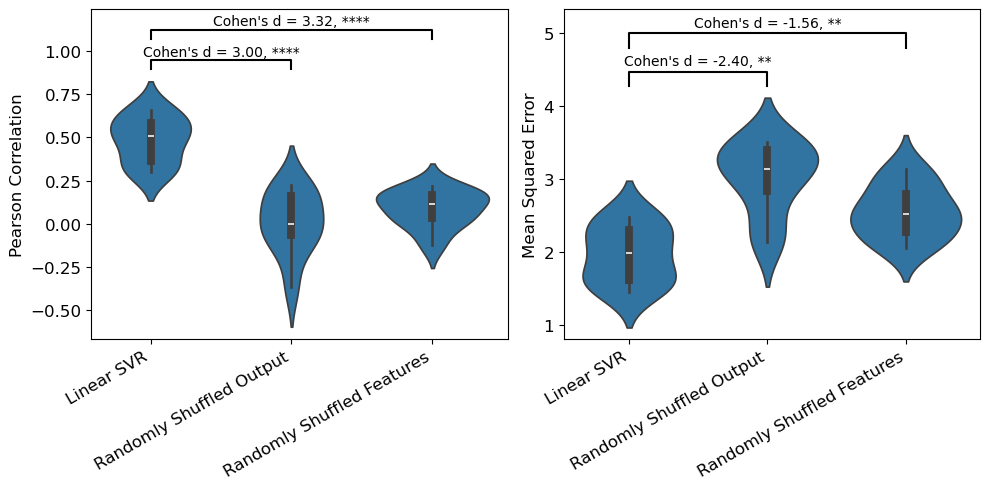

In [28]:
figB, axB = plt.subplots(ncols = 2, figsize = (10,5))

for i, (metric, viz_df) in enumerate(viz_dfs.items()):
    viz_df = pd.melt(viz_df, value_name=metric, var_name = 'Model Type')
    
    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric]: 'Linear SVR', 
                              'random_y_test_' +mmap[metric]: 'Randomly Shuffled Output', 
                             'random_X_test_' +mmap[metric]: 'Randomly Shuffled Features'})
    
    # get statistics
    res_stats, mod_combs = get_stats(viz_df, random = True, metric_type = metric)
    
    sns.violinplot(data = viz_df, x = 'Model Type', y = metric, ax = axB[i])
    
    
    xlabels = [x._text for x in axB[i].get_xticklabels()]
    x_pos = dict(zip(xlabels, axB[i].get_xticks()))
    
    y_lower, y = axB[i].get_ylim()
    h = unit_map['h'][metric]
    
    
    axB[i].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'right')
    
    sig_counter = 0
    for j, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2
        
        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]
        
        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"
        
        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric])
            axB[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                       [y_pos, y_pos+h, y_pos+h, y_pos], 
                       lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric]
            axB[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        axB[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric])
    axB[i].set_xlabel('')
    
    axB[i].title.set_fontsize(axB[i].title.get_fontsize() + 2)
    axB[i].xaxis.label.set_fontsize(axB[i].xaxis.label.get_fontsize() + 2)
    axB[i].yaxis.label.set_fontsize(axB[i].yaxis.label.get_fontsize() + 2)
    for label in axB[i].get_xticklabels() + axB[i].get_yticklabels():
        label.set_fontsize(label.get_fontsize() + 2)


    
    
figB.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'random_transcriptomics.png'), 
            dpi=300, 
            bbox_inches="tight")  

We can see that the Linear SVR outperforms random baselines for both Pearson correlation and MSE. 

Let's also ensure the consensus non-linear SVRs did not perform better than the linear SVRs:

In [29]:
# load in Nikos' NN assessments
nn_res = pd.read_csv(os.path.join(data_path, 'processed', 'transcriptomics_NN_performance_consensusfolds_pearson.csv'), 
                    index_col = 0)

# add mse
nn_res_mse = pd.read_csv(os.path.join(data_path, 'processed', 'transcriptomics_NN_performance_consensusfolds_mse.csv'), 
                    index_col = 0)
nn_res['single model mse'] = nn_res_mse[['single model MSE']]
nn_res['ensemble_mse'] = nn_res_mse[['ensemble_MSE']]



nn_res = nn_res[nn_res.set == 'test'].copy()

nn_res_single = nn_res[['single model r', 'single model mse', 'fold']].copy()


nn_res_ensemble = nn_res[['ensemble_r', 'ensemble_mse', 'fold']].copy()
nn_res_ensemble.drop_duplicates(keep = 'first', inplace = True)
nn_res_ensemble.reset_index(drop = True, inplace = True)

nn_res_single.columns = ['test_corr_single_NN', 'test_mse_single_NN', 'fold']
nn_res_ensemble.columns = ['test_corr_ensemble_NN', 'test_mse_ensemble_NN', 'fold']



In [30]:
viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']]
viz_df = viz_df[[col for col in viz_df if 'random' not in col]]

# add ensemble nn
viz_df = pd.merge(viz_df, nn_res_ensemble, how='inner', on='fold')

viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]]
viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]]
viz_dfs = {'Pearson Correlation': viz_df_corr, 
          'Mean Squared Error': viz_df_mse}
mmap = dict(zip(viz_dfs.keys(), ['corr', 'mse']))

unit_map = {'h': dict(zip(viz_dfs.keys(), [0.05, 0.2])),
            'y_pos_scale_0': dict(zip(viz_dfs.keys(), [0.175, 0.525])),
           'y_pos_scale': dict(zip(viz_dfs.keys(), [1.01, 1.01])), 
           'y_max_scale': dict(zip(viz_dfs.keys(), [1.15, 1.1]))}

/tmp/ipykernel_1306296/4071853409.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axC[i].set_xticklabels(xlabels,
/tmp/ipykernel_1306296/4071853409.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axC[i].set_xticklabels(xlabels,


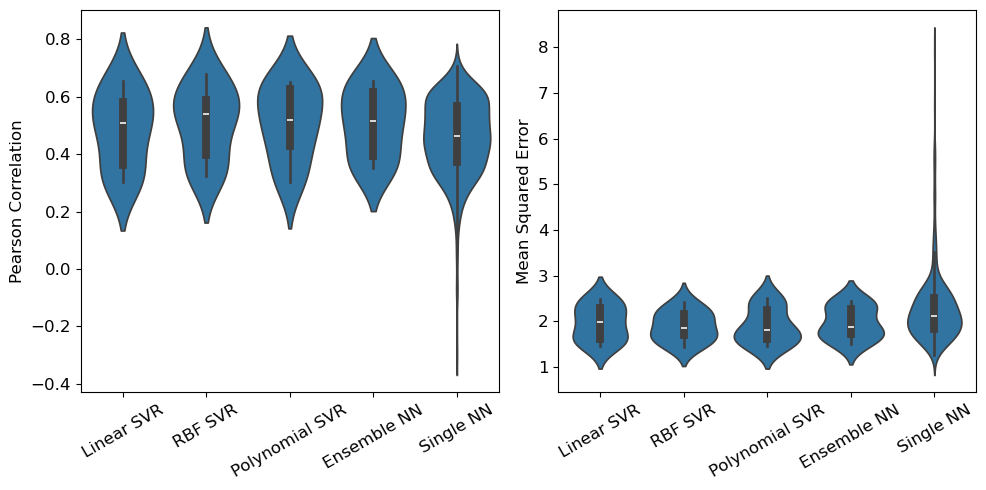

In [31]:
figC, axC = plt.subplots(ncols = 2, figsize = (10,5))

am = {'Pearson Correlation': False, 'Mean Squared Error': True}

for i, (metric, viz_df) in enumerate(viz_dfs.items()):
    viz_df = pd.melt(viz_df, value_name=metric, var_name = 'Model Type')
    
    # add the single NN
    nn_res_single_col = 'test_' + mmap[metric] + '_single_NN'
    nn_res_single_viz = pd.DataFrame(data = {'Model Type': [nn_res_single_col]*nn_res_single.shape[0], 
                         metric: nn_res_single[nn_res_single_col].tolist()
                        })
    viz_df = pd.concat([viz_df, nn_res_single_viz], axis = 0)
    
    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric]: 'Linear SVR', 
                              '_'.join(['test', mmap[metric], 'rbf']): 'RBF SVR', 
                             '_'.join(['test', mmap[metric], 'poly']): 'Polynomial SVR', 
                             '_'.join(['test', mmap[metric], 'ensemble_NN']): 'Ensemble NN',
                             '_'.join(['test', mmap[metric], 'single_NN']): 'Single NN'
                                                    })
#     rank_ordered_models = viz_df.groupby(['Model Type']).std()[metric].sort_values(ascending = True).index.tolist()
#     viz_df['Model Type'] = pd.Categorical(viz_df['Model Type'], 
#                                           categories = rank_ordered_models, 
#                                           ordered = True)

    
    
#     viz_df = viz_df[viz_df[metric].notna()]
    
    # get statistics
    res_stats, mod_combs = get_stats(viz_df, 
                                     random = False, 
                                     metric_type = None # always two-sided
                                    )
    if metric == 'Pearson Correlation':
        pearson_res_stats = res_stats
    
    sns.violinplot(data = viz_df, x = 'Model Type', y = metric,
                   ax = axC[i])
    
#     if metric == 'Mean Squared Error':
#         axC[i].set_yscale('log')
    
    
    xlabels = [x._text for x in axC[i].get_xticklabels()]
    x_pos = dict(zip(xlabels, axC[i].get_xticks()))
    
    y_lower, y = axC[i].get_ylim()
    h = unit_map['h'][metric]
    
    
    axC[i].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
    
    sig_counter = 0
    for j, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2
        
        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]
        
        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"
        
        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric])
            axC[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                       [y_pos, y_pos+h, y_pos+h, y_pos], 
                       lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric]
            axC[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        axC[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric])
    axC[i].set_xlabel('')
    
    axC[i].title.set_fontsize(axC[i].title.get_fontsize() + 2)
    axC[i].xaxis.label.set_fontsize(axC[i].xaxis.label.get_fontsize() + 2)
    axC[i].yaxis.label.set_fontsize(axC[i].yaxis.label.get_fontsize() + 2)
    for label in axC[i].get_xticklabels() + axC[i].get_yticklabels():
        label.set_fontsize(label.get_fontsize() + 2)

#     if i > 0: 
#         axC[i].ticklabel_format(axis='y', style='plain')
#         axC[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
    
    
figC.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'consensus_transcriptomics.png'), 
            dpi=300, 
            bbox_inches="tight")  

There are no significant differences between the consensus models for SVR with any of the tested kernels.